In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Used to load Matlab file
from scipy import io

## Neural Networks

#### Dataset

In [2]:
# load Matlab file
data = io.loadmat('ex4/ex4data1.mat')
print(type(data))

<class 'dict'>


In [3]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [4]:
print(type(data['X']))
print(type(data['y']))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [5]:
# add bias unit
data['X'] = np.insert(data['X'], 0, 1, axis=1)

# feature matrix and response vector
X = data['X']
y = data['y']

In [6]:
print('X shape (with bias unit) : {}'.format(X.shape))

# y is a classification for each image. 1~10, where '10' is the handwritten '0'
print('y shape : {} ; unique elements in y : {}'.format(y.shape, np.unique(y)))

X shape (with bias unit) : (5000, 401)
y shape : (5000, 1) ; unique elements in y : [ 1  2  3  4  5  6  7  8  9 10]


#### Visualization

In [7]:
def getData2Img(featureMatrix):
    """
    Randomly pick 100 rows from feature matrix, each row is 1*400, and creat image object (20*20)
    """
    sample_row = np.random.choice(featureMatrix.shape[0], 100)
    sample_square = []
    for i in sample_row:
        # The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector.
        sample_square.append(featureMatrix[i, 1:].reshape(-1, 20).T)
    return(np.array(sample_square))

def displayImg(featureMatrix):
    for i in range(100):
        plt.subplot(10,10,i+1)
        plt.imshow(getData2Img(X)[i])
        plt.axis('off');

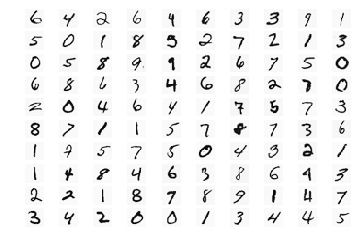

In [8]:
displayImg(X)

## Model Representation

In [9]:
# Use weighted parameters from a neural network that we have already trained.
weights = io.loadmat('ex4/ex4weights.mat')
print(type(weights))

<class 'dict'>


In [10]:
weights.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

In [11]:
print(type(weights['Theta1']))
print(type(weights['Theta2']))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [12]:
# network parameters
Theta1 = weights['Theta1']
Theta2 = weights['Theta2']

print('Theta1 shape : {}'.format(Theta1.shape))
print('Theta2 shape : {}'.format(Theta2.shape))

Theta1 shape : (25, 401)
Theta2 shape : (10, 26)


In [13]:
# Some useful global variables
inputLayer_size = 400  # 20 by 20 grid of pixels (number of features)
hiddenLayer_size = 25
outputLayer_size = 10  # number of classes

# In order to use optimizing functions, we will want to unroll all the elements and put them into one long vector:
theta_unrolled = np.hstack([Theta1.ravel(), Theta2.ravel()])  # unroll parameters 

m = X.shape[0]  # m samples

## Feedforward and Cost Function

In [14]:
# sigmoid function
def sigmoid(z):
    g = 1 / (1 + np.exp(-z))
    return (g)

#### Cost Function for the Neural Network (3 layers)

In [15]:
def computeCostNN(theta_unrolled, inputLayer_size, hiddenLayer_size, outputLayer_size, X, y, lambdaConst):
    """
    Explanation of arguments:
      1. theta_unrolled: Reshape the each theta matrix (from one layer to the next) form the unrolled theta
                         parameters vector. Bias unit is included.
      2. inputLayer_size: number of features of training set
      3. outputLayer_size: number of classes
      4. X: training set matrix, where X contains the bais unit
      5. y: classes. For the purpose of training a neural network, we need to recode the labels as vectors
                     containing only values 0 or 1
    """
    # reshape theta matrix of each layer from unrolled theta parameters vector
    theta1 = theta_unrolled[:hiddenLayer_size*(inputLayer_size+1)] \
             .reshape(hiddenLayer_size, inputLayer_size+1)  # 25*401
    theta2 = theta_unrolled[hiddenLayer_size*(inputLayer_size+1):] \
             .reshape(outputLayer_size, hiddenLayer_size+1)  # 10*26
    
    # one-hot encoding the response vector y
    classes = np.array(pd.get_dummies(y.ravel()).values)  # 5000*10 (10 output units)
        
    # first layer is feature matrix
    a1 = X  # 5000*401
    
    # hidden layer
    z2 = np.dot(a1, theta1.T)  # 5000*25
    a2 = sigmoid(z2)
    a2 = np.insert(a2, 0, 1, axis=1)  # add bias unit, 5000*26

    # output layer
    z3 = np.dot(a2, theta2.T)  # 5000*10
    a3 = sigmoid(z3)
    h = a3  # a3 = h(x)
    
    # cost function for neural networks with regularization, bias unit of theta is skip
    reg_term = (lambdaConst/2/m) * (np.sum(theta1[:, 1:]**2) + np.sum(theta2[:, 1:]**2))
    J = ((-1/m) * np.sum((classes * np.log(h)) + ((1-classes) * np.log(1-h)))) + reg_term
    return (J, a2, a3)

In [16]:
# regularization parameter = 0
print('When lambda = 0, the cost is {}'.format(computeCostNN(theta_unrolled, inputLayer_size, hiddenLayer_size,
                                                             outputLayer_size, X, y, lambdaConst=0)[0]))

When lambda = 0, the cost is 0.2876291651613189


In [17]:
# regularization parameter = 1
print('When lambda = 1, the cost is {}'.format(computeCostNN(theta_unrolled, inputLayer_size, hiddenLayer_size,
                                                             outputLayer_size, X, y, lambdaConst=1)[0]))

When lambda = 1, the cost is 0.38376985909092365


## Backpropagation

#### For sigmoid function, its derivative is $$g'\left( z\right) =g\left( z\right) \left( 1-g\left( z\right) \right)$$

In [18]:
def sigmoidGradient(z):
    g_gradient = sigmoid(z) * (1 - sigmoid(z))
    return (g_gradient)

#### Random initialization

In [19]:
def randInitWeights():
    epsilon_init = 0.12
    theta1_size = (hiddenLayer_size, inputLayer_size+1)  # bias unit included
    theta2_size = (outputLayer_size, hiddenLayer_size+1)  # bias unit included
    
    # Here use a single star * to unpack the tuple into positional arguments
    # https://stackoverflow.com/questions/43587526/pass-shape-tuple-to-numpy-random-rand
    
    random_theta = np.array([np.random.rand(*theta1_size) * 2 * epsilon_init - epsilon_init,
                            np.random.rand(*theta2_size) * 2 * epsilon_init - epsilon_init])
    return (random_theta)

#### Backpropagation
$$\delta ^{\left( 3\right) }=a^{\left( 3\right) }-y$$

$$\delta ^{\left( 2\right) }=\left( \Theta ^{\left( 2\right) }\right) ^{T}\delta ^{\left( 3\right) } \ast g'^{\left( 2\right) }\left( z\right)$$

(Note that there is no error term in first layer.)

In [20]:
def backPropagate(theta_unrolled, inputLayer_size, hiddenLayer_size, outputLayer_size, X, y, lambdaConst):
    """
    Given a training example, we will first run a “forward pass” to compute all the activations.
    For each node j in layer L, compute an “error term” δ(L).
    Then, accumulate the all gradients ∆(L) := ∆(L) + δ(L+1)(a(L))T
    Finally, obtain the gradient for neural network
    """
    # one-hot encoding the response vector y
    classes = np.array(pd.get_dummies(y.ravel()).values)  # 5000*10
    
    # weight parameter
    theta1 = theta_unrolled[:hiddenLayer_size*(inputLayer_size+1)] \
             .reshape(hiddenLayer_size, inputLayer_size+1)  # 25*401
    theta2 = theta_unrolled[hiddenLayer_size*(inputLayer_size+1):] \
             .reshape(outputLayer_size, hiddenLayer_size+1)  # 10*26
    
    # forward propagation
    result = computeCostNN(theta_unrolled, inputLayer_size, hiddenLayer_size, outputLayer_size, X, y, lambdaConst)
    
    # error term
    d3 = result[2] - classes  # 5000*10
    d2 = (np.dot(d3, theta2[:, 1:])) * sigmoidGradient(np.dot(X, theta1.T))  # z2 = np.dot(a1, theta1.T); 5000*25
    
    # accumulate the all gradients
    delta2 = np.dot(d3.T, result[1])  # 10*26
    delta1 = np.dot(d2.T, X)  # 25*401
    
    # obtain the gradient for NN (regularized)
    D2 = (delta2/m) + (lambdaConst*theta2/m)  # 10*26
    D2[0] = D2[0] - (lambdaConst*theta2[0]/m)
    
    D1 = (delta1/m) + (lambdaConst*theta1/m)  # 25*401
    D1[0] = D1[0] - (lambdaConst*theta1[0]/m)
    
    return (np.hstack((D1.ravel(), D2.ravel())))

#### Gradient Checking

In [21]:
def gradCheck(theta_unrolled, inputLayer_size, hiddenLayer_size, outputLayer_size, X, y, lambdaConst):
    """
    1. Use two-point formula to obtain the numerical gradient.
    2. Normalize the 'numerical gradient' and 'backpropagation gradient' respectively.
    3. Then, compute the relative error.
    """
    # compute numerical gradient
    epsilon = 10**(-4)
    cost = computeCostNN(theta_unrolled, inputLayer_size, hiddenLayer_size, outputLayer_size, X, y,
                         lambdaConst)[0]
    numercal_grad = np.zeros_like(theta_unrolled)
    epsilon_vector = np.zeros_like(theta_unrolled)
    for i in range(len(theta_unrolled)):
        epsilon_vector[i] = epsilon
        cost_plus = computeCostNN(theta_unrolled + epsilon_vector, inputLayer_size, hiddenLayer_size,
                                  outputLayer_size, X, y, lambdaConst)[0]
        cost_minus = computeCostNN(theta_unrolled - epsilon_vector, inputLayer_size, hiddenLayer_size,
                                   outputLayer_size, X, y, lambdaConst)[0]
            
        # numerical gradient
        numercal_grad[i] = (cost_plus - cost_minus) / (2*epsilon)
            
        # initial epsilon vector
        epsilon_vector[i] = 0
        
    # backpropagation gradient
    backProp_grad = backPropagate(theta_unrolled, inputLayer_size, hiddenLayer_size, outputLayer_size, X, y,
                                  lambdaConst)
    
    # normalize 'numerical gradient' and 'backpropagation gradient'
    norm1 = np.linalg.norm(numercal_grad - backProp_grad)
    norm2 = np.linalg.norm(numercal_grad)
    norm3 = np.linalg.norm(backProp_grad)
    
    # relative error
    relative_error = norm1 / (norm2 + norm3)
    
    # check gradient (check order of magnitude)
    if int(np.math.log10(relative_error)) <= -7:
        print('relative error = {}. The algorithm is correct'.format(relative_error))
    else:
        print('relative error = {}. The algorithm needs to be modified'.format(relative_error))

In [22]:
gradCheck(theta_unrolled, inputLayer_size, hiddenLayer_size, outputLayer_size, X, y, lambdaConst=0)

relative error = 2.156652318733673e-09. The algorithm is correct


## Visualizing the Hidden Layer

In [23]:
def visualHidden(hidden_param):
    hidden_square = []
    for i in range(hidden_param.shape[0]):
        # The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector.
        hidden_square.append(hidden_param[i, 1:].reshape(-1, 20).T)
    hidden_square = np.array(hidden_square)
    
    # display the hidden layer
    for i in range(hidden_param.shape[0]):
        plt.subplot(5,5,i+1)
        plt.imshow(hidden_square[i])
        plt.axis('off');

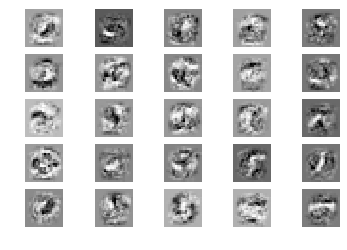

In [24]:
visualHidden(Theta1)